# Trends in Collegiate Men's basketball March Madness Tournament
# Ryan Heany, Ella Van Ness, Noah Haeger 

# data Importation

In [15]:
# we need to import these function for scraping varables from a website
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By 
from selenium.webdriver.chrome.service import Service 
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
import time
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# we are first goingimport our 3 excel files with one of them being the raw scraped file

In [16]:
# after scraping data in a seperate python file, we are now going to load the csv file from that scraped websiste 
# Loading the CSV file as a DataFrame
total_allocation_file = 'Total_allocation_raw.csv'
total_allocation_df = pd.read_csv(total_allocation_file)
print(total_allocation_df.head())

   Rank    School Name Conference  Total Allocated            Key
0     1  Ohio_State_23     Big 10  $225,733,418.00  Ohio_State_23
1     2       Texas_23     Big 12  $225,153,011.00       Texas_23
2     3     Alabama_23        SEC  $195,881,911.00     Alabama_23
3     4    Michigan_23     Big 10  $193,559,375.00    Michigan_23
4     5     Georgia_23        SEC  $169,026,503.00     Georgia_23


## we are going to load a csv file containing Teams generated revenue and other key variables that will help us determine what makes a marhc madness run happen

In [17]:
# Loading CSV file as a DataFrame
# we used two websites to create our csv file
# https://www.axios.com/2023/03/29/ncaa-basketball-tournament-conference-payouts
# https://www.sportico.com/business/commerce/2023/college-sports-finances-database-intercollegiate-1234646029/
teams_generated_rev = ('Generated_Rev.csv')
generated_rev_df = pd.read_csv(teams_generated_rev)
# Printing the column names 
print("Columns in the DataFrame:")
print(generated_rev_df.columns)

Columns in the DataFrame:
Index(['School Name', 'Generated Revenue', 'Seed Rank', 'Year', 'Key'], dtype='object')


In [18]:
# Striping whitespace 
generated_rev_df.columns = generated_rev_df.columns.str.strip()
# we need to find the oclumn to drop
columns_to_drop = [col for col in generated_rev_df.columns if 'Seed Rank' in col]
generated_rev_df = generated_rev_df.drop(columns=columns_to_drop)
# Verifying the columns have been dropped
print("Columns after dropping seed rankings:")
print(generated_rev_df.columns)

Columns after dropping seed rankings:
Index(['School Name', 'Generated Revenue', 'Year', 'Key'], dtype='object')


# we are loading a cvs file containing seed rankings and march madness preformance for the tourneyments of 22 and 23

In [19]:
# Loading the CSV file as a DataFrame
# we used these two websites to create our excel file 
# https://www.statista.com/statistics/219824/teams-with-the-most-ncaa-mens-basketball-final-four-appearances/
# https://www.kaggle.com/datasets/nishaanamin/march-madness-data
seed_rankings_file = 'Seed_rankings_for_2022_2023.csv'
seed_rankings_df = pd.read_csv(seed_rankings_file)
# Displaying first few rows
print(seed_rankings_df.head())

   YEAR School Name  SEED  ROUND  POWER RATING  POWER RATING RANK         Key
0  2023     Houston     1     16          93.2                 13  Houston_23
1  2023     Alabama     1     16          92.6                 16  Alabama_23
2  2023      Kansas     1     32          89.6                 49   Kansas_23
3  2023      Purdue     1     64          89.5                 50   Purdue_23
4  2023       Texas     2      8          90.1                 43    Texas_23


In [20]:
#showing the shape of the seed rankings df
seed_rankings_df.shape

(136, 7)

#### Next we are going to clean the df for variables we do not need

In [21]:
# Dropping power ranking column
seed_rankings_df = seed_rankings_df.drop(columns=['POWER RATING RANK'])
# Displaying updated DataFrame
print(seed_rankings_df.head())

   YEAR School Name  SEED  ROUND  POWER RATING         Key
0  2023     Houston     1     16          93.2  Houston_23
1  2023     Alabama     1     16          92.6  Alabama_23
2  2023      Kansas     1     32          89.6   Kansas_23
3  2023      Purdue     1     64          89.5   Purdue_23
4  2023       Texas     2      8          90.1    Texas_23


# we are now preforming an outer join with the three excel files
# we are joining by the key column, each entry contains a key which includes school_name_year

In [22]:
# we are preforming an outer join
generated_rev_df.rename(columns={'Key': 'key'}, inplace=True)
seed_rankings_df.rename(columns={'Key': 'key'}, inplace=True)
total_allocation_df.rename(columns={'Key': 'key'}, inplace=True)

# Perform an outer join on the "key" column across all three DataFrames
merged_data = (
    generated_rev_df.merge(seed_rankings_df, on='key', how='outer')
                    .merge(total_allocation_df, on='key', how='outer')
)

# Save the resulting merged dataset to a new CSV file
output_file = 'Merged_Dataset.csv'
merged_data.to_csv(output_file, index=False)

# Print confirmation and dataset details
print(f"Merged dataset saved successfully as '{output_file}'.")
print(f"Shape of the merged dataset: {merged_data.shape}") 

Merged dataset saved successfully as 'Merged_Dataset.csv'.
Shape of the merged dataset: (438, 13)


In [23]:
# we are checking the columns to ensure they were merged
merged_data.columns

Index(['School Name_x', 'Generated Revenue', 'Year', 'key', 'YEAR',
       'School Name_y', 'SEED', 'ROUND', 'POWER RATING', 'Rank', 'School Name',
       'Conference', 'Total Allocated'],
      dtype='object')

## preforming data cleaning with merged dataset

In [24]:
# Drop the specified columns
columns_to_drop = ['Year', 'YEAR', 'School Name_y', 'School Name_x', 'School Name']
merged_data_cleaned = merged_data.drop(columns=columns_to_drop, errors='ignore')
# Save the cleaned dataset to a new CSV file
output_file_cleaned = 'Cleaned_Merged_Dataset.csv'
merged_data_cleaned.to_csv(output_file_cleaned, index=False)
# Print confirmation and shape of the cleaned dataset
print(f"Cleaned dataset saved successfully as '{output_file_cleaned}'.")
print(f"Shape of the cleaned dataset: {merged_data_cleaned.shape}")

Cleaned dataset saved successfully as 'Cleaned_Merged_Dataset.csv'.
Shape of the cleaned dataset: (438, 8)


# Question 1
## What is the  revenue of teams in 2022/2023 March Madness that were in the final 4?
## How does this revenue compare to Teams who did not make the final 4?

In [25]:
# Loading the dataset
file_path = ('Updated_Cleaned_Merged_Dataset.csv') 
data = pd.read_csv(file_path)
data['ROUND'] = pd.to_numeric(data['ROUND'], errors='coerce')
# Filtering the data where ROUND == 4.0
final_4_schools = data[data['ROUND'] == 4.0].copy()
final_4_schools['Generated Revenue'] = pd.to_numeric(final_4_schools['Generated Revenue'], errors='coerce')
# Calculating average revenue
average_revenue_final_4 = final_4_schools['Generated Revenue'].mean()
# Printing the Final 4 teams
print("\nFinal 4 Teams with Revenues:")
print(final_4_schools[['key', 'Generated Revenue', 'ROUND']])
# Printing the results
print(f"\nThe average revenue of Final 4 teams is: ${average_revenue_final_4:,.2f}")


Final 4 Teams with Revenues:
                    key  Generated Revenue  ROUND
12              Duke_22         41356329.0    4.0
13  Florida_Atlantic_23          5231997.0    4.0
34          Miami_FL_23         18221449.0    4.0
52         Villanova_22         23567445.0    4.0

The average revenue of Final 4 teams is: $22,094,305.00


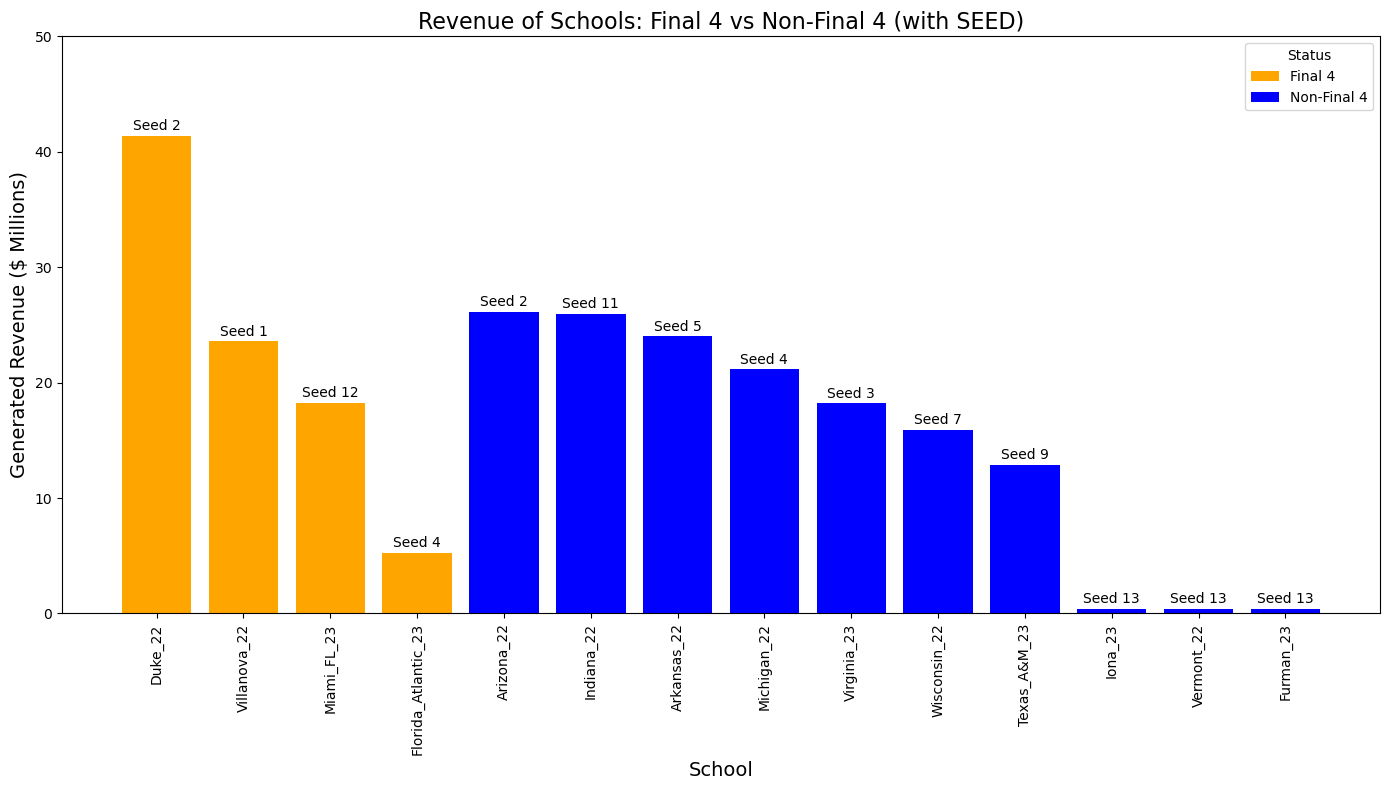

In [26]:
file_path = ('Cleaned_Updated_Dataset.csv')
data = pd.read_csv(file_path)
 # Cleaning 'Generated Revenue' column
if data['Generated Revenue'].dtype == 'object':
    data['Generated Revenue'] = data['Generated Revenue'].str.replace(r'[\$,]', '', regex=True)
    data['Generated Revenue'] = pd.to_numeric(data['Generated Revenue'], errors='coerce')
data['ROUND'] = pd.to_numeric(data['ROUND'], errors='coerce')

# removing missing columns
data = data.dropna(subset=['key', 'Generated Revenue', 'ROUND'])
data = data[data['Generated Revenue'] > 0] 

# Filter Final 4 teams (ROUND == 4)
final_4_schools = data[data['ROUND'] == 4.0].copy()
non_final_4_schools = data[data['ROUND'] != 4.0].copy()
if len(non_final_4_schools) >= 10:
    non_final_4_schools = non_final_4_schools.sample(10, random_state=42)
else:
    print("Warning: Less than 10 Non-Final 4 schools are available.")
final_4_schools['Status'] = 'Final 4'
non_final_4_schools['Status'] = 'Non-Final 4'
combined_data = pd.concat([final_4_schools, non_final_4_schools])
combined_data = combined_data.sort_values(by='Generated Revenue', ascending=False)
combined_data['Generated Revenue (Millions)'] = combined_data['Generated Revenue'] / 1e6
# we are are structing our plot
plt.figure(figsize=(14, 8))
colors = {'Final 4': 'orange', 'Non-Final 4': 'blue'}
bars = []
# Create bars for each status
for status in combined_data['Status'].unique():
    subset = combined_data[combined_data['Status'] == status]
    bars.extend(plt.bar(subset['key'], subset['Generated Revenue (Millions)'], label=status, color=colors[status]))
# Annotate each bar with the SEED value
for bar, seed in zip(bars, combined_data['SEED']):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 0.5, 
             f"Seed {int(seed)}" if not pd.isna(seed) else "N/A", 
             ha='center', fontsize=10)
# Setting custom y-axis ticks
plt.yticks(np.arange(0, combined_data['Generated Revenue (Millions)'].max() + 10, 10))
# Add labels and title
plt.title('Revenue of Schools: Final 4 vs Non-Final 4 (with SEED)', fontsize=16)
plt.ylabel('Generated Revenue ($ Millions)', fontsize=14)
plt.xlabel('School', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.legend(title='Status')
plt.tight_layout()
plt.show()


# Question #3
# Which team has the lowest revenue worst seed ranking?
# does this Revenue track between all other teams with that same seed?

In [27]:
# code for finding lowest revenue and worst seed ranking
data['SEED'] = pd.to_numeric(data['SEED'], errors='coerce')
filtered_data = data.dropna(subset=['Generated Revenue', 'SEED'])
sorted_data = filtered_data.sort_values(by=['Generated Revenue', 'SEED'])
lowest_revenue_best_seed = sorted_data.iloc[0]
# Display the result
print("Team with the lowest revenue but best seed ranking:")
print(lowest_revenue_best_seed[['key', 'Generated Revenue', 'SEED']])

Team with the lowest revenue but best seed ranking:
key                  Akron_22
Generated Revenue    371234.0
SEED                     13.0
Name: 0, dtype: object


Pearson Correlation Coefficient: 0.2081
P-value: 0.6210
Fail to reject H0: No significant correlation (correlation = 0).


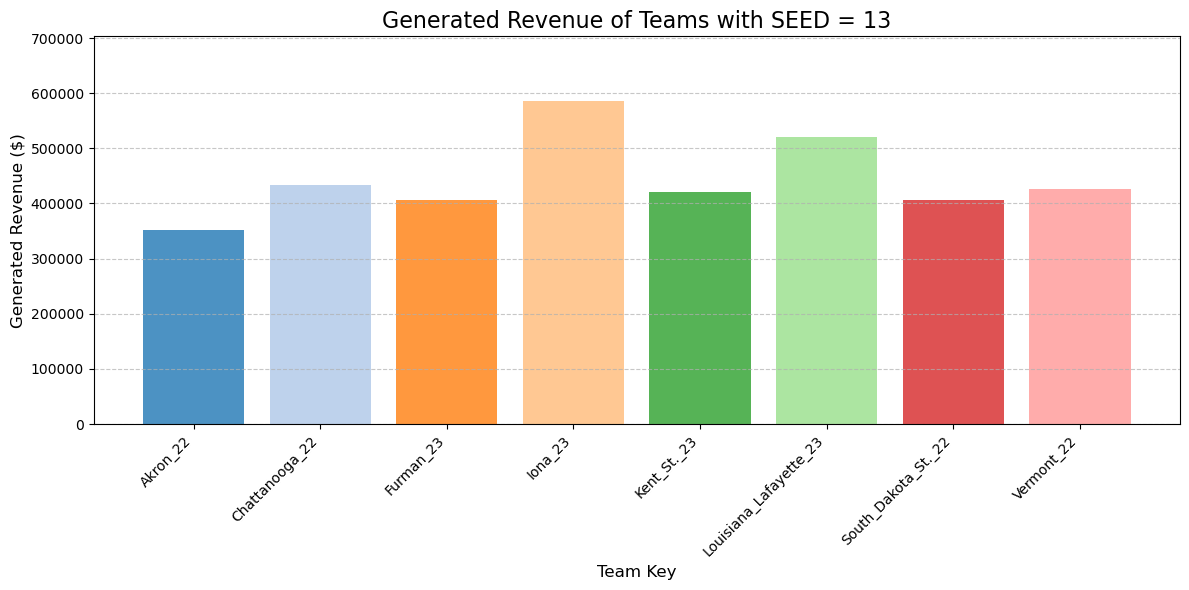

In [28]:
# now creating a plot for our question
file_path = ('Updated_Cleaned_Merged_Dataset.csv')
data = pd.read_csv(file_path)
data['Generated Revenue'] = data['Generated Revenue'].replace(r'[\$,]', '', regex=True)
data['Generated Revenue'] = pd.to_numeric(data['Generated Revenue'], errors='coerce')
# Filter data for teams with SEED = 13.0
seed_13_teams = data[data['SEED'] == 13.0]
correlation, p_value = pearsonr(seed_13_teams['ROUND'], seed_13_teams['Generated Revenue'])
# Displaying the results
print(f"Pearson Correlation Coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")
# Determining the significance
alpha = 0.05
if p_value < alpha:
    print("Reject H0: Significant correlation exists (correlation ≠ 0).")
else:
    print("Fail to reject H0: No significant correlation (correlation = 0).")
plt.figure(figsize=(12, 6))
colors = plt.cm.tab20(range(len(seed_13_teams)))
plt.bar(seed_13_teams['key'], seed_13_teams['Generated Revenue'], color=colors, alpha=0.8)
plt.title('Generated Revenue of Teams with SEED = 13', fontsize=16)
plt.xlabel('Team Key', fontsize=12)
plt.ylabel('Generated Revenue ($)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, seed_13_teams['Generated Revenue'].max() * 1.2)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
cleaned_data = data.dropna(subset=['Generated Revenue'])
# Saving the cleaned data to a new CSV
cleaned_file_path = 'Cleaned_Dataset_With_Revenue.csv'
cleaned_data.to_csv(cleaned_file_path, index=False)

##  Which team has the highest revenue and best ranking?

In [29]:
# Loading the dataset
file_path = 'Updated_Cleaned_Merged_Dataset.csv'
data = pd.read_csv(file_path)
data['Generated Revenue'] = pd.to_numeric(data['Generated Revenue'], errors='coerce')
data['SEED'] = pd.to_numeric(data['SEED'], errors='coerce')
filtered_data = data.dropna(subset=['Generated Revenue', 'SEED'])
# Sort by 'Generated Revenue' (descending) and 'SEED' (descending) to prioritize highest revenue and lowest seed
sorted_data = filtered_data.sort_values(by=['Generated Revenue', 'SEED'], ascending=[False, False])
highest_revenue_lowest_seed = sorted_data.iloc[0]
# Displaying the result
print("Team with the highest revenue but lowest seed ranking:")
print(highest_revenue_lowest_seed[['key', 'Generated Revenue', 'SEED']])

Team with the highest revenue but lowest seed ranking:
key                     Duke_22
Generated Revenue    41356329.0
SEED                        2.0
Name: 12, dtype: object


Pearson Correlation Coefficient: 0.0422
P-value: 0.9283
Fail to reject H0: No significant correlation (correlation = 0).


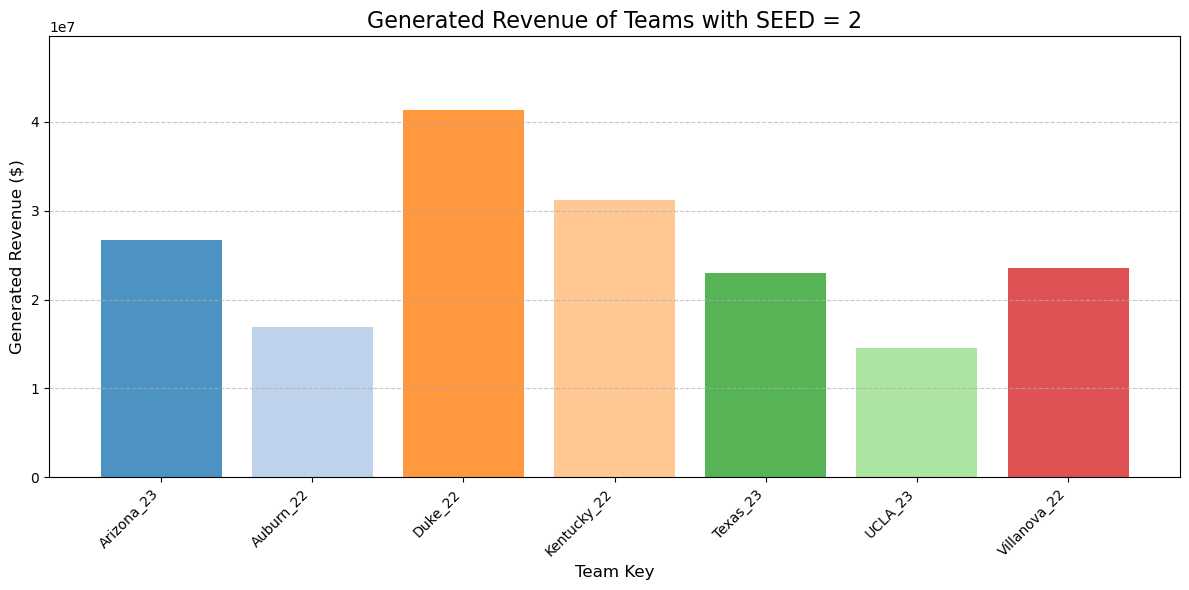

In [30]:
# now doing the code for the chart
file_path = 'Updated_Cleaned_Merged_Dataset.csv'
data = pd.read_csv(file_path)
data['Generated Revenue'] = data['Generated Revenue'].replace(r'[\$,]', '', regex=True)
data['Generated Revenue'] = pd.to_numeric(data['Generated Revenue'], errors='coerce')
# Filtering data for teams with SEED = 2.0
seed_2_teams = data[data['SEED'] == 2.0].dropna(subset=['ROUND', 'Generated Revenue'])  # Drop rows with NaNs
if len(seed_2_teams) > 1:  # Ensure there are enough data points
    correlation, p_value = pearsonr(seed_2_teams['ROUND'], seed_2_teams['Generated Revenue'])

    # Displaying the results
    print(f"Pearson Correlation Coefficient: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Determining the significance
    alpha = 0.05
    if p_value < alpha:
        print("Reject H0: Significant correlation exists (correlation ≠ 0).")
    else:
        print("Fail to reject H0: No significant correlation (correlation = 0).")
else:
    print("Not enough data points to compute Pearson correlation.")

# Bar chart comparing all teams with SEED = 2 and their Generated Revenues
plt.figure(figsize=(12, 6))
colors = plt.cm.tab20(range(len(seed_2_teams)))  
plt.bar(seed_2_teams['key'], seed_2_teams['Generated Revenue'], color=colors, alpha=0.8)
plt.title('Generated Revenue of Teams with SEED = 2', fontsize=16)
plt.xlabel('Team Key', fontsize=12)
plt.ylabel('Generated Revenue ($)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, seed_2_teams['Generated Revenue'].max() * 1.2) 
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
cleaned_data = data.dropna(subset=['Generated Revenue'])
cleaned_file_path = ('Cleaned_Dataset_With_Revenue.csv')

# Question #4
# which conference has the highest revenue?

In [31]:
import pandas as pd

# Load the dataset
file_path = 'Updated_Cleaned_Merged_Dataset.csv'
data = pd.read_csv(file_path)

# Ensure 'Total Allocated' is numeric (remove dollar signs and commas)
data['Total Allocated'] = data['Total Allocated'].str.replace(r'[\$,]', '', regex=True).astype(float)

# Group by 'Conference' and sum the 'Total Allocated'
conference_revenue = data.groupby('Conference', as_index=False)['Total Allocated'].sum()

# Sort by total revenue and display the top conference
sorted_revenues = conference_revenue.sort_values(by='Total Allocated', ascending=False)

# Display the conference with the highest total revenue
top_conference = sorted_revenues.iloc[0]
top_conference_name = top_conference['Conference']
top_conference_revenue = top_conference['Total Allocated']

print(f"Conference with the highest revenue:\nConference: {top_conference_name}\nTotal Revenue: ${top_conference_revenue:,.2f}")


Conference with the highest revenue:
Conference: SEC
Total Revenue: $1,105,814,563.00


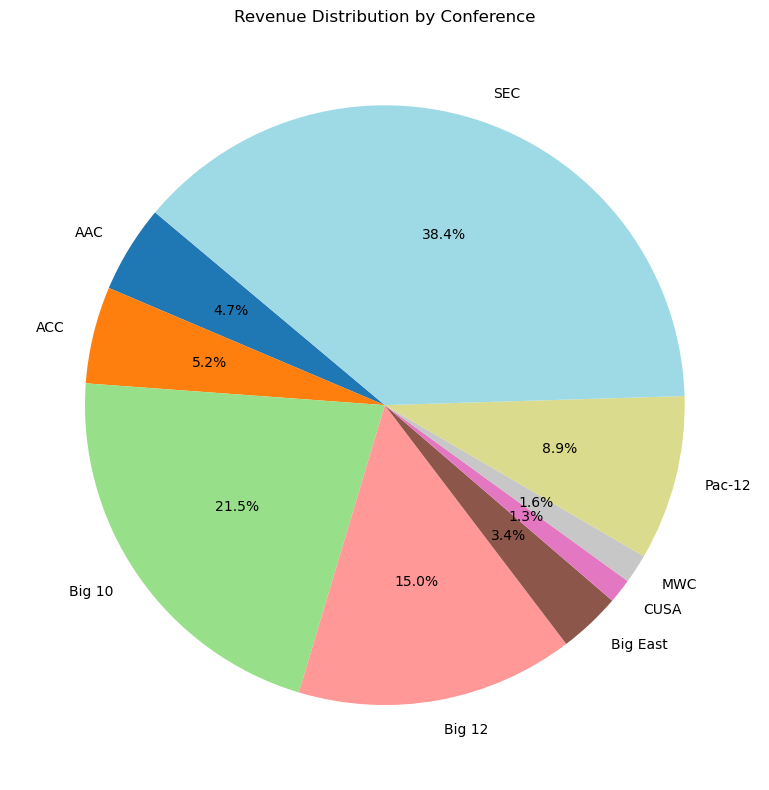

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'Updated_Cleaned_Merged_Dataset.csv' 
data = pd.read_csv(file_path)

# Clean and convert 'Total Allocated' to numeric
data['Total Allocated'] = (
    data['Total Allocated']
    .replace(r'[\$,]', '', regex=True)  # Use raw string to avoid escape sequence warnings
    .astype(float)  # Convert to float
)

# Group by 'Conference' and sum up 'Total Allocated'
conference_revenue_totals = data.groupby('Conference')['Total Allocated'].sum().dropna()

# Create the pie chart
plt.figure(figsize=(8, 8))
conference_revenue_totals.plot.pie(
    autopct='%1.1f%%', startangle=140, colormap='tab20', fontsize=10, legend=False
)
plt.title("Revenue Distribution by Conference")
plt.ylabel("")  # Remove y-axis label for clarity
plt.tight_layout()
plt.show()

# 

# Question #5
# showing the outlier within our data 
# is this ourtlier because of the amounts of revenue?

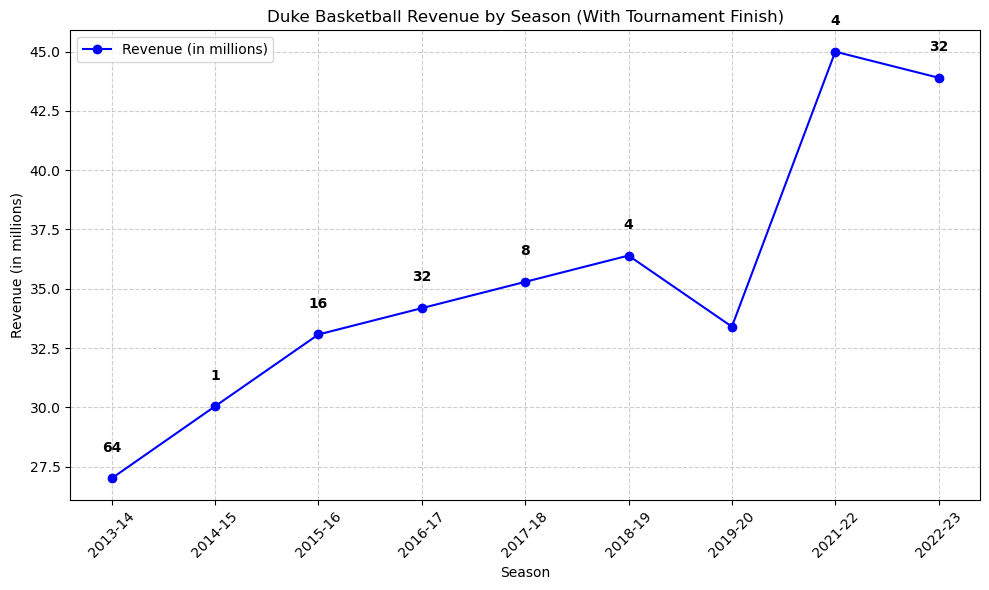

In [33]:
# Load your dataset
file_path = 'Updated_Duke_Basketball_Revenue.csv'  
data = pd.read_csv(file_path)

# Ensure numeric columns are properly formatted
data['Revenue (in millions)'] = pd.to_numeric(data['Revenue (in millions)'], errors='coerce')
data['Tournament Finish'] = pd.to_numeric(data['Tournament Finish'], errors='coerce')

# Create a line chart for Revenue by Season
plt.figure(figsize=(10, 6))

# Plot the revenue data
plt.plot(data['Season'], data['Revenue (in millions)'], marker='o', color='blue', label='Revenue (in millions)')

# Add annotations for Tournament Finish
for i, row in data.iterrows():
    if pd.notna(row['Tournament Finish']): 
        plt.text(
            row['Season'], 
            row['Revenue (in millions)'] + 1,  
            f"{int(row['Tournament Finish'])}",  
            color='black', fontsize=10, fontweight='bold', ha='center', va='bottom'
        )

# Format the chart
plt.title("Duke Basketball Revenue by Season (With Tournament Finish)")
plt.xlabel("Season")
plt.ylabel("Revenue (in millions)")
plt.xticks(rotation=45)  
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the chart
plt.show()